<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [ ]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2025.11.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install pyTEMlib --upgrade
# ------------------------------
print('done')

### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [1]:
%matplotlib widget
import sys
import numpy as np
import matplotlib.pylab as plt

# using  pyTEMlib.eds_tools, pyTEMlib.file_tools and pyTEMlib.eels_tools (for line definitions)

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../../')
import pyTEMlib


if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'EDS_Spectrum_Analysis'
__notebook_version__ = '2025_10_27'

pyTEM version:  0.2025.12.0


## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [2]:
#path =  "C:\Users\gduscher\OneDrive - University of Tennessee\google_drive\2022 Experiments\Spectra\20221214\AlCe-200kV"
fileWidget = pyTEMlib.file_tools.FileWidget()

fileWidget.filename

### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

Here we sum the spectra of the 4 quadrants and define the detector parameter.

sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<add, shape=(215, 178, 2048), dtype=uint16, chunksize=(215, 178, 2048), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  distance (nm) of size (215,)
y:  distance (nm) of size (178,)
energy_scale:  energy (eV) of size (2048,)
 with metadata: ['experiment', 'EDS', 'filename']


sidpy.Dataset of type SPECTRAL_IMAGE with:
 dask.array<add, shape=(215, 178, 2048), dtype=uint16, chunksize=(215, 178, 2048), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  distance (nm) of size (215,)
y:  distance (nm) of size (178,)
energy_scale:  energy (eV) of size (2048,)
 with metadata: ['experiment', 'EDS', 'filename']

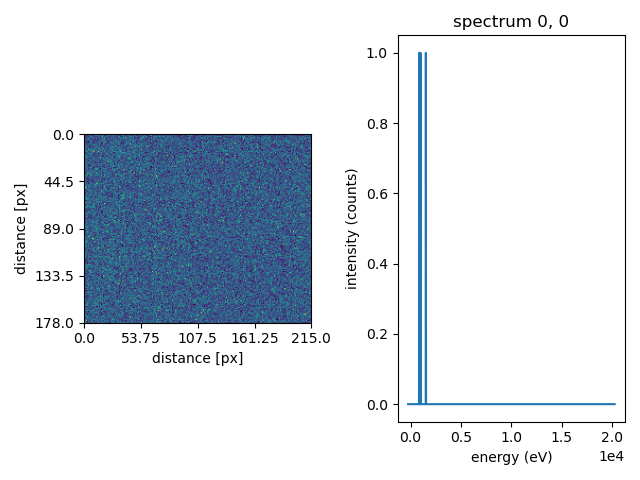

In [3]:
dataset = fileWidget.selected_dataset
view = dataset.plot()
print(dataset)
dataset

### Rigid Registration and Atom Finding
Select the Image stack

In [4]:
chooser = pyTEMlib.file_tools.ChooseDataset(fileWidget.datasets)

Dropdown(description='select dataset:', options=('Channel_000: Mn', 'Channel_001: Mg', 'Channel_002: Ni', 'Cha…

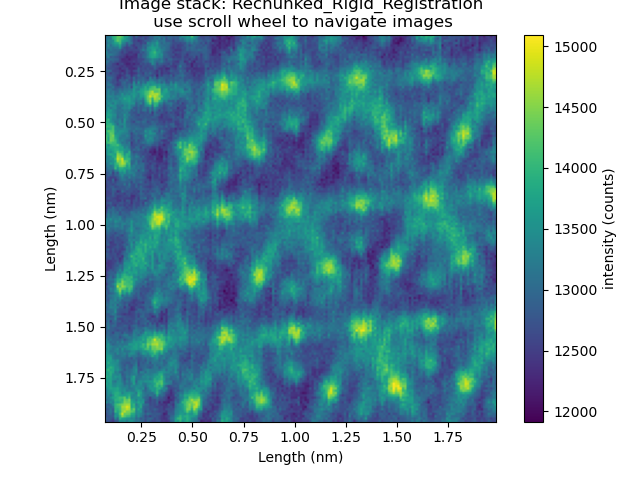

In [5]:
haadf = chooser.dataset
rigid_registered = pyTEMlib.image_tools.rigid_registration(haadf)
v = rigid_registered.plot()

Visualize Drift

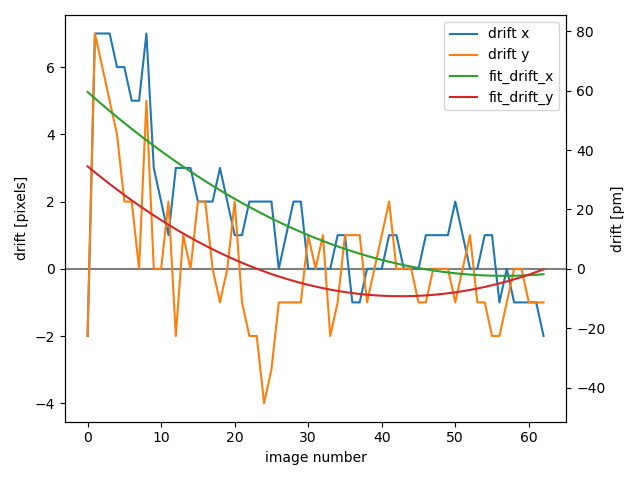

In [6]:
drift = rigid_registered.metadata['analysis']['rigid_registration']['drift']
polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...

x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)

plt.figure()
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')

plt.legend();
ax_pixels = plt.gca()
ax_pixels.step(1, 1)

scaleX = (rigid_registered.x[1]-rigid_registered.x[0])*1000.  #in pm

ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()

ax_pm.set_ylim(x_1*scaleX, x_2*scaleX)

ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

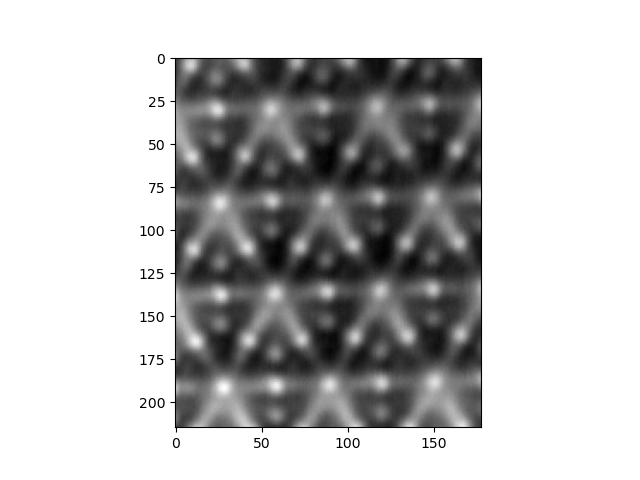

In [7]:
haadf_sum = haadf.sum(axis=0)
haadf_sum.data_type = 'image'
plt.figure()
plt.imshow(haadf_sum.T, cmap='gray');

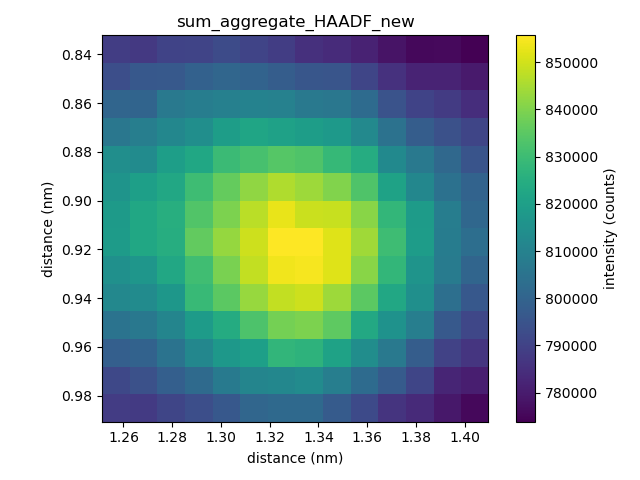

In [8]:
width = 14
position = np.array([118,81])-int(width/2)
atom = haadf_sum[position[0]:position[0]+width, position[1]:position[1]+width]
atom.data_type = 'image'
atom.plot();

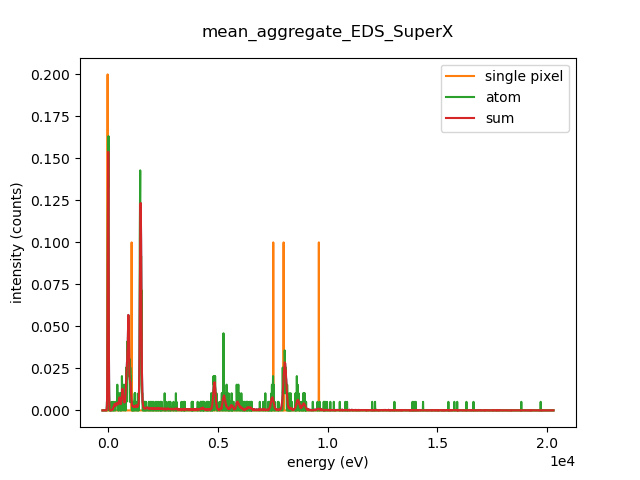

In [9]:
atom_sum = dataset[position[0]:position[0]+width, position[1]:position[1]+width]
atom_sum= atom_sum.mean(axis=(0,1))

spectrum_sum = dataset.mean(axis=(0,1))
spectrum_sum.data_type = 'spectrum'
view = spectrum_sum.plot();
plt.gca().plot(spectrum_sum.energy_scale.values, np.array(dataset[87,84])/10, label='single pixel');  
plt.gca().plot(spectrum_sum.energy_scale.values, atom_sum, label='atom')
plt.gca().plot(spectrum_sum.energy_scale.values, spectrum_sum, label='sum')
plt.gca().legend();

In [10]:
### Does not work for spectrum images
# 
spectrum = dataset.sum(axis=(0,1))
spectrum.data_type = 'spectrum'
start = np.searchsorted(spectrum.energy_scale.values, 100)
energy_scale = spectrum.energy_scale.values[start:]
detector_Efficiency= pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])
if 'start_energy' not in spectrum.metadata['EDS']['detector']:
    spectrum.metadata['EDS']['detector']['start_energy'] = 120
spectrum[:np.searchsorted(spectrum.energy_scale.values,spectrum.metadata['EDS']['detector']['start_energy'])] = 0.
spectrum.metadata['EDS']['detector']['detector_efficiency']  = detector_Efficiency

## Find Elements 

c:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\array\core.py:1744: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


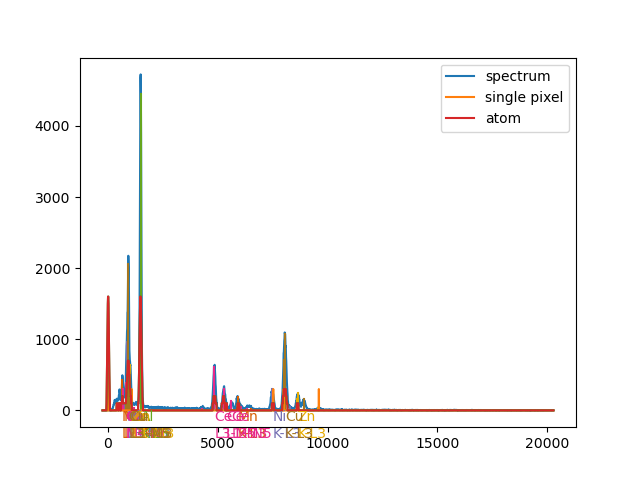

In [11]:
# --------Input -----------
minimum_number_of_peaks = 10
# --------------------------
import scipy
pyTEMlib.eds_tools.get_elements(spectrum, minimum_number_of_peaks, verbose=False)
atom_sum = dataset[position[0]:position[0]+width, position[1]:position[1]+width]
atom_sum= atom_sum.sum(axis=(0,1))
atom_sum = scipy.ndimage.gaussian_filter1d(atom_sum, sigma=3)
single = dataset[87,84]
plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.gca().plot(spectrum_sum.energy_scale.values, np.array(single)*300, label='single pixel');  
plt.gca().plot(spectrum_sum.energy_scale.values, atom_sum*100)
plt.gca().plot(spectrum_sum.energy_scale.values, atom_sum*100, label='atom')
#plt.gca().plot(spectrum_sum.energy_scale.values, spectrum, label='sum')
plt.legend();


Viziualization what happens at the atomic scale.

We plot the difference between the atom signal and the total signal of the spectrum-image 
 

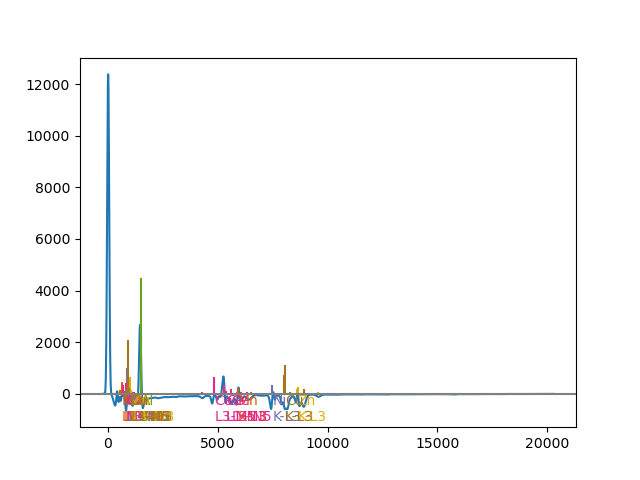

In [12]:
atom_sum = dataset[position[0]:position[0]+width, position[1]:position[1]+width]
atom_sum= atom_sum.sum(axis=(0,1))
atom_sum = scipy.ndimage.gaussian_filter1d(atom_sum, sigma=3)   
spectrum_ref = spectrum/spectrum.sum()*atom_sum.sum()
spectrum_ref = scipy.ndimage.gaussian_filter1d(spectrum_ref, sigma=3)
difference = atom_sum - spectrum_ref
difference = difference -np.mean(difference)
#difference[difference < 0] = 0
difference = scipy.ndimage.gaussian_filter1d(difference, sigma=3)
plt.figure()
plt.plot(spectrum.energy_scale,difference*1000, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(0, color='gray')


## Quantify

### Fit spectrum

In [36]:
spectrum = dataset.sum(axis=(0,1))
spectrum.data_type = 'spectrum'
atom_sum = dataset[position[0]:position[0]+width, position[1]:position[1]+width]
atom_sum = atom_sum.sum(axis=(0,1))
atom_sum = scipy.ndimage.gaussian_filter1d(atom_sum, sigma=3)
spectrum_atom = spectrum.like_data(atom_sum).copy()
spectrum_atom.data_type = 'spectrum'

In [37]:
spectrum.metadata['EDS'].keys()
#del spectrum.metadata['EDS']['O']

dict_keys(['detector', 'Mn', 'Ni', 'Ce', 'Al', 'Zn', 'Cu', 'bremsstrahlung', 'GUI', 'quantification'])

no intensity Ce M-family


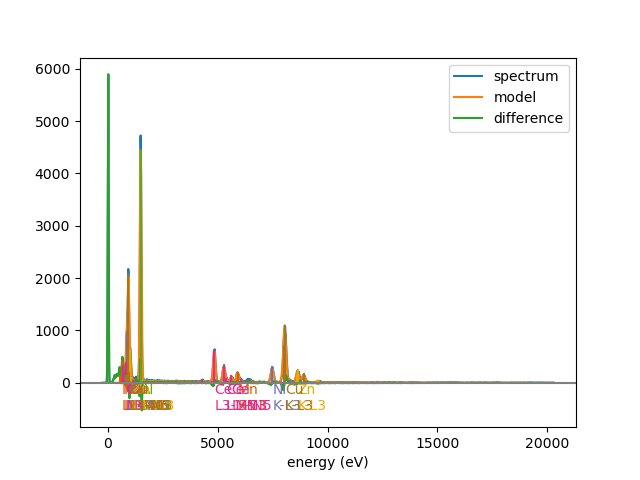

In [38]:
import pyTEMlib.eds_tools
peaks, pp = pyTEMlib.eds_tools.fit_model(spectrum, use_detector_efficiency=True)
model = pyTEMlib.eds_tools.get_model(spectrum)

plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, np.array(spectrum-model), label='difference')
plt.xlabel('energy (eV)')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.legend()

### Quantify Spectrum
first with Bote-Salvat cross section
using dictionaries calculated with [emtables package](https://github.com/adriente/emtables/blob/main/).

In [39]:
pyTEMlib.eds_tools.quantify_eds(spectrum, mask=[])

using cross sections for quantification
Mn: 2.89 at% 3.15 wt%
Ni: 5.33 at% 6.19 wt%
Ce: 9.87 at% 27.37 wt%
Al: 55.13 at% 29.44 wt%
Zn: 4.80 at% 6.21 wt%
Cu: 21.98 at% 27.64 wt%


then with k-factor dictionary

In [40]:
print('whole spectrum-image')

q_dict = pyTEMlib.eds_tools.load_k_factors()
tags = pyTEMlib.eds_tools.quantify_eds(spectrum, q_dict, mask = [])
print(spectrum.metadata['EDS']['GUI'])

print('\n single_atom')
peaks2, pp2 = pyTEMlib.eds_tools.fit_model(spectrum_atom, use_detector_efficiency=True)
model2 = pyTEMlib.eds_tools.get_model(spectrum_atom)

tags2 = pyTEMlib.eds_tools.quantify_eds(spectrum_atom, q_dict, mask = [])
print(spectrum.metadata['EDS']['GUI'])

whole spectrum-image
using L k-factor for Ce
using k-factors for quantification
Mn: 2.71 at% 3.22 wt%
Ni: 4.80 at% 6.10 wt%
Ce: 7.18 at% 21.79 wt%
Al: 61.52 at% 35.96 wt%
Zn: 4.24 at% 6.00 wt%
Cu: 19.56 at% 26.93 wt%
excluded from quantification  []
{'Mn': {'symmetry': 'K-family', 'atom%': np.float64(2.7051287700413416), 'weight%': np.float64(3.219379032174964), 'excluded': False, 'k_factor': 0.424546, 'intensity': np.float64(2865.6151737265586)}, 'Ni': {'symmetry': 'K-family', 'atom%': np.float64(4.8014387023481095), 'weight%': np.float64(6.104453939518709), 'excluded': False, 'k_factor': 0.465132, 'intensity': np.float64(4959.536747966664)}, 'Ce': {'symmetry': 'L-family', 'atom%': np.float64(7.1795223901909395), 'weight%': np.float64(21.792497544797623), 'excluded': False, 'k_factor': 0.531928, 'intensity': np.float64(15481.91449182895)}, 'Al': {'symmetry': 'K-family', 'atom%': np.float64(61.51561068256205), 'weight%': np.float64(35.95528641123943), 'excluded': False, 'k_factor': 0.3

In [23]:
tags = pyTEMlib.eds_tools.quantify_eds(spectrum, q_dict, mask = [])


using L k-factor for Ce
using k-factors for quantification
Mn: 2.67 at% 3.26 wt%
Ni: 3.64 at% 4.75 wt%
Ce: 7.74 at% 24.09 wt%
Al: 65.92 at% 39.50 wt%
Zn: 3.62 at% 5.25 wt%
Cu: 16.41 at% 23.15 wt%
excluded from quantification  []


### Absorption Correction
Lower energy lines will be more affected than higher x-ray lines.

At thin sample location (<50nm) absorption is not significant.

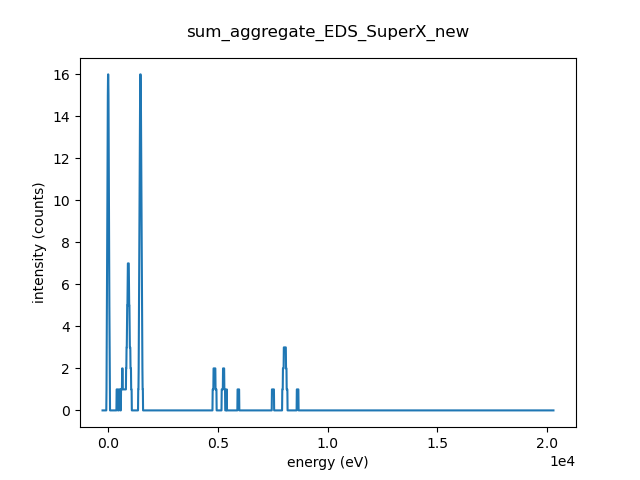

In [25]:
v = spectrum_atom.plot()

In [54]:
# ------ Input ----------
thickness_in_nm = 150
# -----------------------
pyTEMlib.eds_tools.apply_absorption_correction(spectrum, thickness_in_nm)
for key, value in spectrum.metadata['EDS']['GUI'].items():
    if 'corrected-atom%' in value:
        print(f"Element: {key}, Corrected Atom%: {value['corrected-atom%']:.2f}, Corrected Weight%: {value['corrected-weight%']:.2f}")

Element: Mn, Corrected Atom%: 2.59, Corrected Weight%: 3.14
Element: Ce, Corrected Atom%: 6.88, Corrected Weight%: 21.26
Element: Zn, Corrected Atom%: 4.05, Corrected Weight%: 5.84
Element: Al, Corrected Atom%: 63.18, Corrected Weight%: 37.60
Element: Ni, Corrected Atom%: 4.59, Corrected Weight%: 5.94
Element: Cu, Corrected Atom%: 18.71, Corrected Weight%: 26.21


## Summary
The spectrum is modeled completely with background and characteristic peak-families.

Either 
- k-factors in a file (here from Spectra300) or
- Bothe-Salvat cross-sections
 
are used for quantification.

## Appendix
### Background
The determined background used for the model-based quantification is based on the detector effciency.

Note:

The detector efficiency is also used for the quantification model.
